# Imports

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import cluster
from matplotlib import gridspec
from shapely.geometry import Point
from sklearn.metrics import silhouette_score
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Functions

In [2]:
def groupby_min(df, dur):
    temp = df.copy()
    temp.index = map(lambda x: pd.datetime.combine(datetime.datetime.today()
                                                   , x), temp.index.time)
    return temp.resample(dur).mean()

def plot_camera_avg(df, cam=None, dur="1Min"):
    if cam == None:
        weekday = groupby_min(df[(df.index.weekday < 5) & 
                                 (df.index != "2017-07-04")], dur)
        weekend = groupby_min(df[(df.index.weekday >= 5)], dur)
        july4 = groupby_min(df[(df.index > "2017-07-04") & 
                               (df.index < "2017-07-05")], dur)
    else:
        weekday = groupby_min(df[(df.index.weekday < 5) & 
                                 (df.cam_id == cam) & 
                                 (df.index != "2017-07-04")], dur)
        weekend = groupby_min(df[(df.index.weekday >= 5) & 
                                 (df.cam_id == cam)], dur)
        july4 = groupby_min(df[(df.index > "2017-07-04") & 
                               (df.index < "2017-07-05") & 
                               (df.cam_id == cam)], dur)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
    
    july4["count"].plot(ax=ax1, c="r", alpha=0.4, label="July 4th")
    weekday["count"].plot(ax=ax1, c="k", alpha=0.5, label="Weekday")
    weekend["count"].plot(ax=ax1, c="b", alpha=0.5, label="Weekend")

    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.grid(True, which="both")
    ax1.tick_params(axis="both", which="both", labelsize=12)
    ax1.legend(ncol=3, fontsize=12)
    
    return fig, ax1

# Load Data

In [3]:
df = pd.read_csv("../data/external/hadive-data.csv",
                 usecols=["cam_id", "date", "cam_dir", "count", "imtime"],
                 dtype={"cam_id": int, "date": str, "cam_dir": str, 
                        "count": int, "imtime": str}, parse_dates=["date"], 
                 infer_datetime_format=True, index_col="date")

print df.dtypes
df.head(2)

cam_id      int64
cam_dir    object
count       int64
imtime     object
dtype: object


,cam_id,cam_dir,count,imtime
date,,,,
2017-06-27 20:09:22,368,S,1,NaN
2017-06-27 20:09:23,360,NaN,1,NaN


In [4]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0.0,1.0,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1.0,0.0,Queens,11367


# Cameras Average (Manhattan)

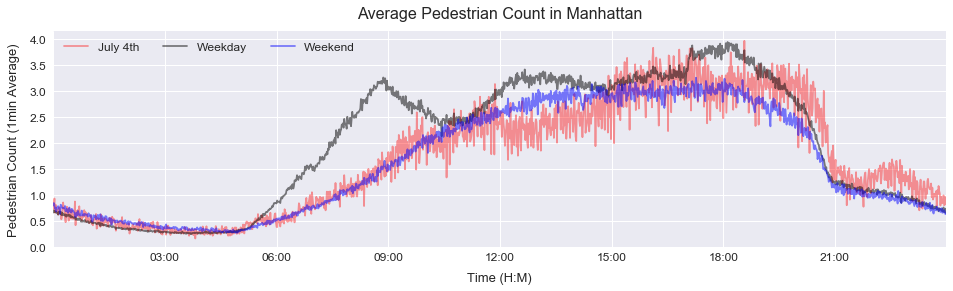

In [5]:
df_man = df[df["cam_id"].isin(cams[(cams["boro"] == "Manhattan") & 
                                   (cams["people"] == 1.)].cam_id.unique())]
fig, ax1 = plot_camera_avg(df_man)
ax1.set_xlabel("Time (H:M)", fontsize=13, labelpad=10)
ax1.set_ylabel("Pedestrian Count (1min Average)", fontsize=13, labelpad=10)
ax1.set_title("Average Pedestrian Count in Manhattan", fontsize=16, y=1.03)

# Camera Average (Weekday, Weekend, and July 4th).

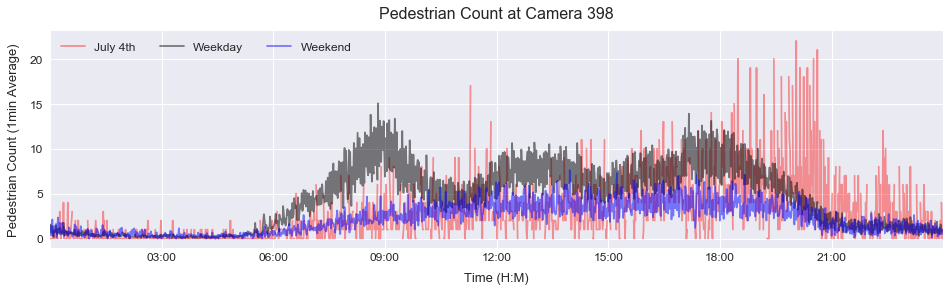

In [6]:
cam_id = 398 # Edit camera id here.
fig, ax1 = plot_camera_avg(df, cam_id, "1Min") 

ax1.set_xlabel("Time (H:M)", fontsize=13, labelpad=10)
ax1.set_ylabel("Pedestrian Count (1min Average)", fontsize=13, labelpad=10)
ax1.set_title("Pedestrian Count at Camera {}".format(cam_id), fontsize=16, y=1.03)

['5 Ave @ 49 St']


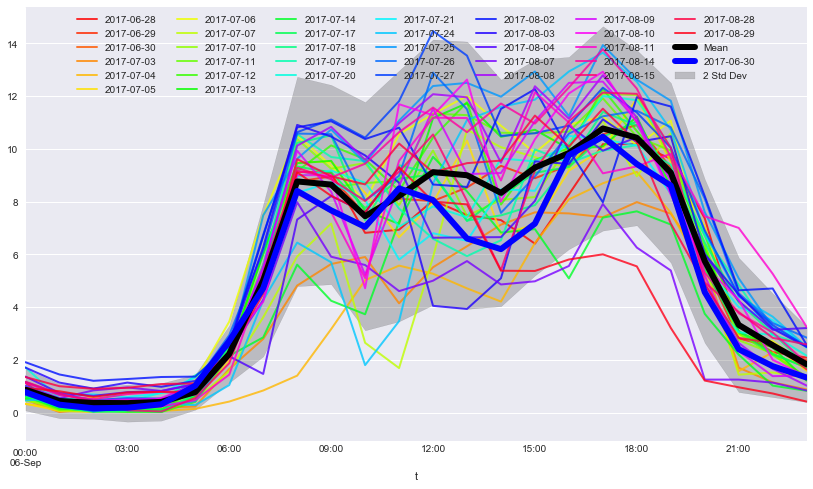

In [148]:
cam = 169
test = df_man[(df_man.cam_id == cam) & (df_man.index.weekday < 5)].copy()[["count"]]
test["d"] = test.index.date
test["t"] = map(lambda x: pd.datetime.combine(pd.datetime.today(), x), test.index.time)

test = test.groupby(["d", "t"]).mean() \
            .unstack(level=0) \
            .resample("60min").mean() \
            .dropna(axis=1).T
test.index = test.index.droplevel(0)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(14, 8))
test.T.plot(ax=ax1, alpha=0.8, colormap="hsv", lw=2)
test.mean().T.plot(ax=ax1, c="k", label="Mean", lw=6)
test[test.index == pd.datetime(2017, 6, 30).date()].T.plot(ax=ax1, c="b", lw=6)
ax1.fill_between(test.T.index, 
                 test.mean().T + 2*test.std().values, 
                 test.mean().T - 2*test.std().values, 
                 alpha=0.2, color="k", label="2 Std Dev")
ax1.legend(ncol=7, loc="upper center")
print cams[cams.cam_id == cam]["description"].values
# ax1.set_ylim(0, 16)

In [102]:
df.groupby("cam_id").mean()[["count"]].sort_values("count", ascending=False).head(10)

,count
cam_id,
899,10.370448
181,6.923655
475,6.445082
523,6.397130
501,6.197993
170,5.457272
535,5.352674
169,5.159516
180,4.929060
